## Libraries to import

In [2]:
from datetime import datetime, timedelta
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt

import joblib

import hashlib
import json

## Importing the dataset

In [3]:
all_prices = pd.read_csv('prices_30m.csv')

In [4]:
end_date = datetime.now()
start_date = end_date - timedelta(days=60)
end_date = "2025-11-24"
horizon = "30m"

print("Start date:", start_date)
print("End date:", end_date)

Start date: 2025-10-03 21:03:08.000968
End date: 2025-11-24


In [5]:
gold = yf.download("GC=F", start = start_date, end = end_date, interval = horizon, auto_adjust = False)
silver = yf.download("SI=F", start = start_date, end = end_date, interval = horizon,auto_adjust = False)
cad = yf.download("CADUSD=X", start = start_date, end = end_date, interval = horizon, auto_adjust = False)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [6]:
all_prices = all_prices.dropna().drop(columns=['Datetime'])

In [7]:
all_prices.head()

,Gold,Silver,CAD
0,3726.300049,43.514999,0.724864
1,3726.300049,43.514999,0.724879
2,3726.300049,43.514999,0.724743
3,3726.300049,43.514999,0.724428
4,3726.300049,43.514999,0.724071


In [8]:
all_prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2819 entries, 0 to 2818
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Gold    2819 non-null   float64
 1   Silver  2819 non-null   float64
 2   CAD     2819 non-null   float64
dtypes: float64(3)
memory usage: 66.2 KB


In [9]:
all_prices.describe()

,Gold,Silver,CAD
count,2819.000000,2819.000000,2819.000000
mean,3996.124167,48.199035,0.715737
std,172.775878,3.028758,0.004873
min,3721.399902,43.514999,0.707269
25%,3853.799927,46.627501,0.712431
50%,4016.399902,48.195000,0.714464
75%,4125.299805,50.567499,0.718161
max,4394.299805,57.080002,0.728014


In [10]:
scaler = MinMaxScaler()
scaled = scaler.fit_transform(all_prices)

joblib.dump(scaler, "scaler_30m.pkl")
print("Scaler saved")

Scaler saved


In [11]:
def create_sequences(data, timesteps):
    X, y = [], []
    for i in range(len(data) - timesteps):
        X.append(data[i : i + timesteps])
        y.append(data[i + timesteps])
    return np.array(X), np.array(y)

In [12]:
max_window = 60

X, y = create_sequences(scaled, max_window)
X.shape

(2759, 60, 3)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=False)

## RNN

## Hyperparameter tuning

In [14]:
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

def mae(y_true, y_pred):
    return tf.reduce_mean(tf.abs(y_true - y_pred))

def mape(y_true, y_pred):
    return tf.reduce_mean(tf.abs((y_true - y_pred) / (y_true + 1e-8))) * 100

In [15]:
def model_builder(hp):
    model = keras.Sequential([
        keras.layers.SimpleRNN(
            units=hp.Int("units_1", min_value=16, max_value=128, step=16),
            return_sequences=True,
            input_shape=(hp.Int("window", min_value=10, max_value=100, step=10), 3),
            kernel_regularizer=keras.regularizers.l2(hp.Choice("l2_reg", values=[1e-6, 1e-5, 1e-4]))
        ),
        keras.layers.Dropout(hp.Float("dropout_1", min_value=0.1, max_value=0.3, step=0.05)),
        keras.layers.SimpleRNN(
            units=hp.Int("units_2", min_value=8, max_value=64, step=8),
            return_sequences=False,
            kernel_regularizer=keras.regularizers.l2(hp.Choice("l2_reg2", [1e-6, 1e-5, 1e-4])),
        ),
        keras.layers.Dropout(hp.Float("dropout_2", min_value=0.1, max_value=0.3, step=0.05)),
        keras.layers.Dense(3, activation="relu") #output
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(hp.Choice("learning_rate", [1e-2, 5e-3, 1e-3, 5e-4, 1e-4])),\
        loss="mse",
        metrics=[rmse, mae, mape]
    )

    return model

In [16]:
tuner = kt.Hyperband(
    model_builder,
    objective=kt.Objective("val_rmse", direction="min"),
    max_epochs=40,
    max_consecutive_failed_trials=5,
    seed=42,
    directory="tuning_results",
    project_name="gold_silver_cad",
)

Reloading Tuner from tuning_results/gold_silver_cad/tuner0.json


In [17]:
stop_early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5
)

In [18]:
tuner.search(x=X_train, y=y_train, validation_split=0.15, callbacks=[stop_early])

### Metrics evaluation of the best model

In [19]:
best_model = tuner.get_best_models(1)[0]
best_model.save('rnn_30m.keras')
best_model.summary()

I0000 00:00:1764702274.570449  116675 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10065 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4080 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9
/home/rita/anaconda3/envs/Python3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/home/rita/anaconda3/envs/Python3.11/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 40, 128)        │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 40, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 64)             │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,443 (115.01 KB)

 Trainable params: 29,443 (115.01 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_hps.values

{'units_1': 128,
 'window': 40,
 'l2_reg': 1e-06,
 'dropout_1': 0.1,
 'units_2': 64,
 'l2_reg2': 1e-06,
 'dropout_2': 0.15000000000000002,
 'learning_rate': 0.001,
 'tuner/epochs': 40,
 'tuner/initial_epoch': 14,
 'tuner/bracket': 2,
 'tuner/round': 2,
 'tuner/trial_id': '0070'}

In [21]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

model = best_model

y_pred = model.predict(X_test)

y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test)

rmse_val = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
mae_val  = mean_absolute_error(y_test_inv, y_pred_inv)
mape_val = mean_absolute_percentage_error(y_test_inv, y_pred_inv)

print("RMSE:", rmse_val)
print("MAE :", mae_val)
print("MAPE:", mape_val)

2025-12-02 21:04:38.575717: I external/local_xla/xla/service/service.cc:163] XLA service 0x74ce18004d50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-12-02 21:04:38.575737: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 4080 Laptop GPU, Compute Capability 8.9
2025-12-02 21:04:38.587501: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-12-02 21:04:38.612722: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91400
2025-12-02 21:04:38.619178: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-02 21:04:38.

 1/13 ━━━━━━━━━━━━━━━━━━━━ 11s 974ms/step

I0000 00:00:1764702279.450505  117201 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2025-12-02 21:04:39.591820: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-02 21:04:39.591835: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-02 21:04:39.886133: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_26', 16 bytes sp

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step 
RMSE: 6.5439001976415225
MAE : 2.706056498003084
MAPE: 0.0020639398841817524


In [22]:
baseline = scaler.inverse_transform(X_test[:, -1, :])

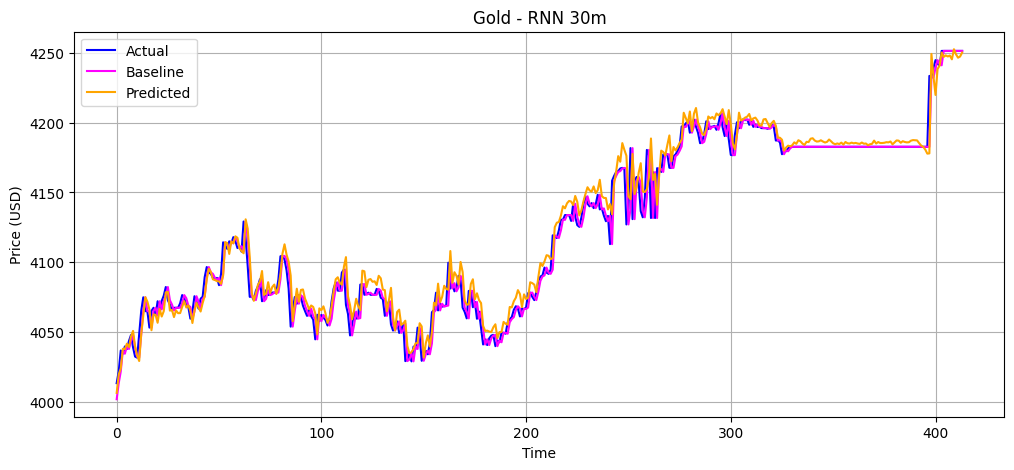

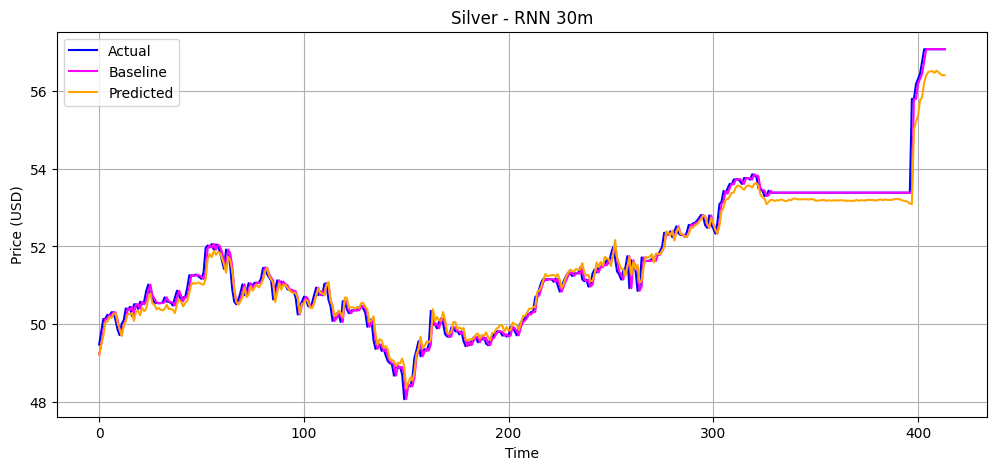

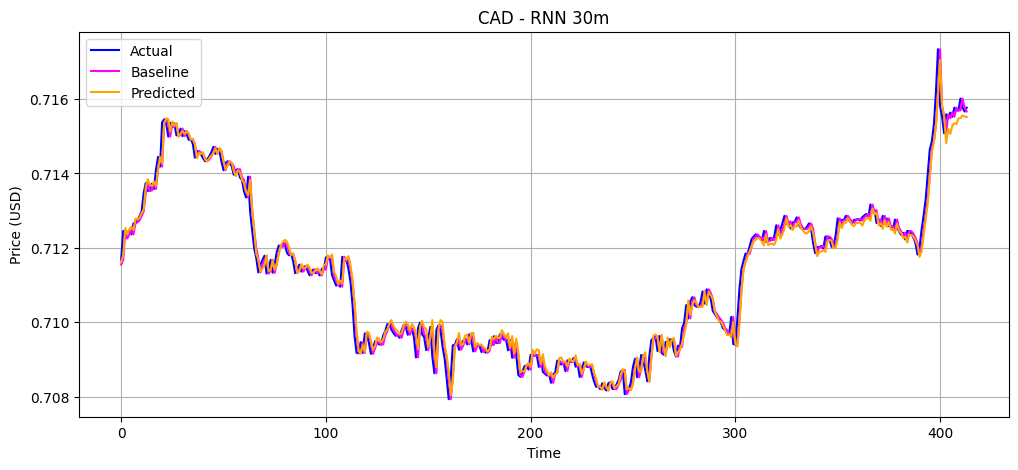

In [23]:
def plot_asset(i, asset_name):
    plt.figure(figsize=(12,5))
    plt.plot(y_test_inv[:, i], label="Actual", color="blue")
    plt.plot(baseline[:, i], label="Baseline", color="magenta")
    plt.plot(y_pred_inv[:, i], label="Predicted", color="orange")
    plt.title(f"{asset_name} - RNN 30m")
    plt.xlabel("Time")
    plt.ylabel("Price (USD)")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_asset(0, "Gold")
plot_asset(1, "Silver")
plot_asset(2, "CAD")

In [24]:
def mae(y, p): return np.mean(np.abs(y-p))
def rmse(y, p): return np.sqrt(np.mean((y-p)**2))
def mape(y, p): return np.mean(np.abs((y-p)/y))*100

assets = ["Gold","Silver","CAD"]
for i in range(3):
    print(assets[i])
    print(" MAE :", mae(y_test_inv[:,i], y_pred_inv[:,i]))
    print(" RMSE:", rmse(y_test_inv[:,i], y_pred_inv[:,i]))
    print(" MAPE:", mape(y_test_inv[:,i], y_pred_inv[:,i]))
    print()

Gold
 MAE : 7.9119012067859344
 RMSE: 11.33059005889141
 MAPE: 0.19229397154856864

Silver
 MAE : 0.20604205477064907
 RMSE: 0.29260589642817664
 MAPE: 0.3950878251265967

CAD
 MAE : 0.0002262324526690033
 RMSE: 0.00031113494125607646
 MAPE: 0.031800168579360875



# Final testing cell

2025-12-02 21:17:33.303215: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-02 21:17:33.331842: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-02 21:17:33.947120: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
I0000 00:00:1764703054.344795  118229 gpu_device.cc:2020] Created device /job:localhost/rep

Enter date range exactly in this format inside the parenthesis, with the start date first (DD-MM-YYYY; DD-MM-YYYY): 20-11-2025; 28-11-2025


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
/home/rita/anaconda3/envs/Python3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/rita/anaconda3/envs/Python3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
2025-12-02 21:18:03.780557: I external/local_xla/xla/service/service.cc:163] XLA service 0x7f0224004a50 initialized for platform CUDA (this does not guarantee

1/8 ━━━━━━━━━━━━━━━━━━━━ 6s 929ms/step

I0000 00:00:1764703084.616173  118382 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step


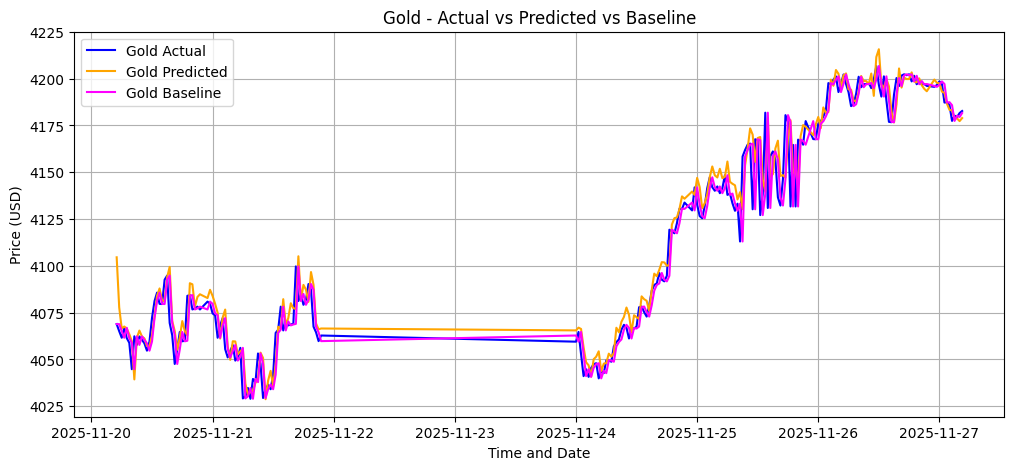

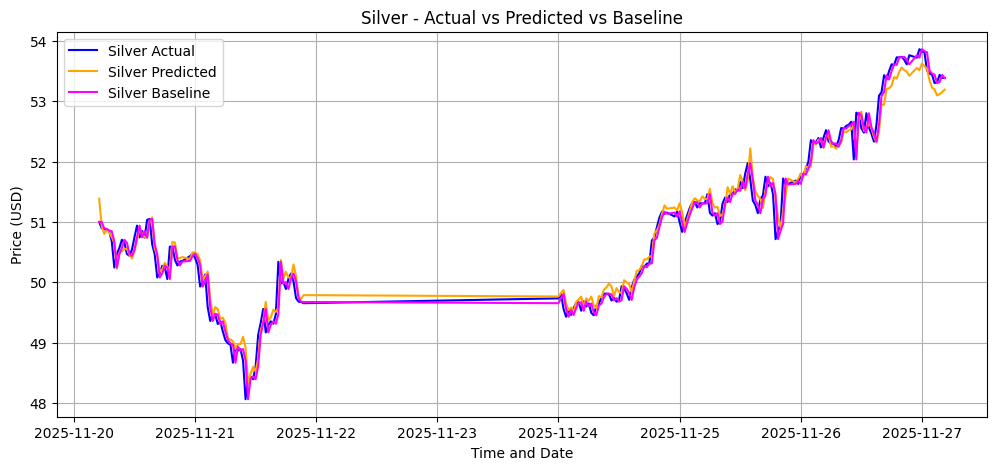

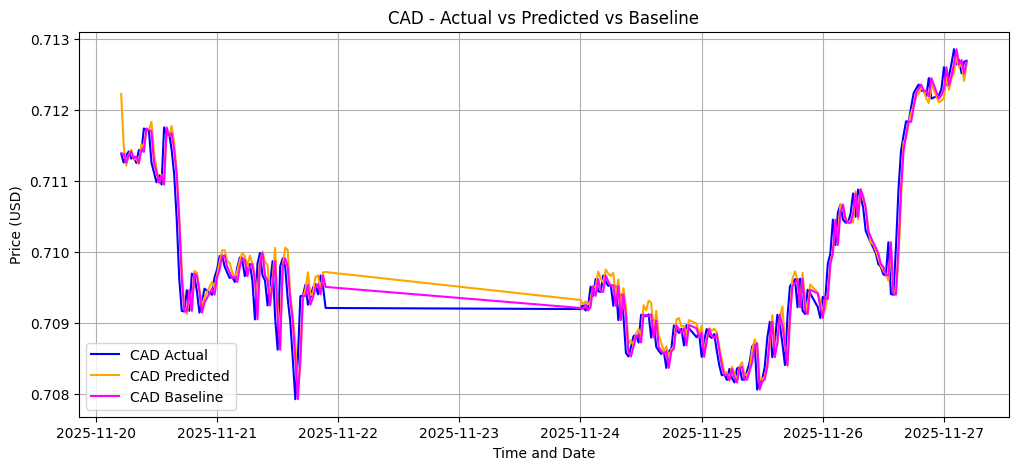

In [1]:
from datetime import datetime, timedelta
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import load_model
import joblib

predict_window = 40

def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

def mae(y_true, y_pred):
    return tf.reduce_mean(tf.abs(y_true - y_pred))

def mape(y_true, y_pred):
    return tf.reduce_mean(tf.abs((y_true - y_pred) / (y_true + 1e-8))) * 100

model = load_model("rnn_30m.keras",
    custom_objects={"rmse": rmse, "mae": mae, "mape": mape}
)

scaler = joblib.load("scaler_30m.pkl")


def parse_range(user_input): #format: DD-MM-YYYY; DD-MM-YYYY
   # Example: 10-12-2025; 14-12-2025
    if ";" not in user_input:
        raise ValueError("Invalid format. Use: DD-MM-YYYY; DD-MM-YYYY")

    parts = user_input.split(";")
    if len(parts) != 2:
        raise ValueError("Invalid format. Use: DD-MM-YYYY; DD-MM-YYYY")

    start_str = parts[0].strip()
    end_str   = parts[1].strip()

    try:
        start = datetime.strptime(start_str, "%d-%m-%Y")
        end   = datetime.strptime(end_str, "%d-%m-%Y")
    except:
        raise ValueError("Invalid date. Use exactly this format: DD-MM-YYYY; DD-MM-YYYY")

    return start, end

def user_date():
    while True:
        user_input = input("Enter date range exactly in this format inside the parenthesis, with the start date first (DD-MM-YYYY; DD-MM-YYYY): ")

        try:
            start, end = parse_range(user_input)
            return user_input
        except Exception as e:
            print(f"\nError: {str(e)}\nPlease try again.\n")


def predict_range(date_string, interval="30m"):
    start, end = parse_range(date_string)

    # downloading data to be able to compare with the actual value only!!!!
    gold = yf.download("GC=F", start=start, end=end, interval=interval, auto_adjust = False)[["Close"]].rename(columns={"Close": "Gold"})
    silver = yf.download("SI=F", start=start, end=end, interval=interval, auto_adjust = False)[["Close"]].rename(columns={"Close": "Silver"})
    cad = yf.download("CADUSD=X", start=start, end=end, interval=interval, auto_adjust = False)[["Close"]].rename(columns={"Close": "CAD"})
    
    
    data = gold.join([silver, cad], how="outer").dropna()

    if data.shape[0] == 0:
        raise ValueError(
            f"No Yahoo Finance data found between {start.date()} and {end.date()} "
            f"for interval='{interval}'. "
            "Try an earlier date range that already has price history."
        )
    
    # past data for for sequence creation
    past_start = start - pd.Timedelta(days=30)

    gold_past = yf.download("GC=F", start=past_start, end=start, interval=interval, auto_adjust=False)[["Close"]].rename(columns={"Close": "Gold"})
    silver_past = yf.download("SI=F", start=past_start, end=start, interval=interval, auto_adjust=False)[["Close"]].rename(columns={"Close": "Silver"})
    cad_past = yf.download("CADUSD=X", start=past_start, end=start, interval=interval, auto_adjust=False)[["Close"]].rename(columns={"Close": "CAD"})

    past = gold_past.join([silver_past, cad_past], how="outer").dropna()
    
    # we did not fit the scaler on future data, we loaded the old scaler
    scaled_past = scaler.transform(past)
    scaled_data = scaler.transform(data)

    X_seq = []
    last_seq = scaled_past[-predict_window:]
    window = np.vstack([scaled_past[-predict_window:], scaled_data])

    for i in range(len(data)):
        seq = window[i:i+predict_window]
        if seq.shape[0] == predict_window:
            X_seq.append(seq)

    X_seq = np.array(X_seq)

    preds = model.predict(X_seq)
    preds_inv = scaler.inverse_transform(preds)

    data["Gold_pred"], data["Silver_pred"], data["CAD_pred"] = (
        preds_inv[:, 0], preds_inv[:, 1], preds_inv[:, 2]
    )

    return data


def plot_results(df):
    assets = ["Gold", "Silver", "CAD"]
    for asset in assets:
        actual = df[asset].values
        predicted = df[f"{asset}_pred"].values
        
        # baseline: next price = current actual
        baseline = np.roll(actual, 1)
        baseline[0] = actual[0]  

        plt.figure(figsize=(12,5))
        plt.plot(df.index, actual, label=f"{asset} Actual", color="blue")
        plt.plot(df.index, predicted, label=f"{asset} Predicted", color="orange")
        plt.plot(df.index, baseline, label=f"{asset} Baseline", color="magenta")
        
        plt.title(f"{asset} - Actual vs Predicted vs Baseline")
        plt.xlabel("Time and Date")
        plt.ylabel("Price (USD)")
        plt.legend()
        plt.grid(True)
        plt.show()


# 20-11-2025; 28-11-2025
user_range = user_date()
user_df = predict_range(user_range, interval="30m")
plot_results(user_df)

In [2]:
user_df.head()

Price,Gold,Silver,CAD,Gold_pred,Silver_pred,CAD_pred
Ticker,GC=F,SI=F,CADUSD=X,,,
Datetime,,,,,,
2025-11-20 05:00:00+00:00,4068.899902,51.000000,0.711389,4104.563477,51.384464,0.712228
2025-11-20 05:30:00+00:00,4065.100098,50.895000,0.711263,4077.841797,50.933823,0.711499
2025-11-20 06:00:00+00:00,4061.600098,50.884998,0.711364,4066.521973,50.803730,0.711219
2025-11-20 06:30:00+00:00,4066.899902,50.860001,0.711420,4067.601318,50.865051,0.711374
2025-11-20 07:00:00+00:00,4061.399902,50.845001,0.711318,4066.523193,50.821335,0.711442
